# Trabalho 1 - Tópicos Especiais em Matemática Aplicada

**Alunos/Matricula:** João V. Farias & Renan V. Guedes / 221022604 & 221031363

**Arquitetura Usada:**

**Dataset Link:** [V1: Nonsegmented single plants (1.7GB)](https://vision.eng.au.dk/?download=/data/WeedData/Nonsegmented.zip)


### Rede Neural para determinar espécia de uma muda, dada sua imagem.

**Sobre o Dataset:** O dataset de mudas de plantas contém imagens de aproximadamente `960 plantas únicas` pertencentes a `12 espécies` em vários estágios de crescimento. Ele compreende imagens RGB anotadas com uma resolução física de aproximadamente `10 pixels por mm`.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Colab Notebooks/Nonsegmented'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tratamento dos dados

- ?Redisionamento (uniformizar o tamanho das imagens) ☑️
- Normalização (valores dos pixels entre 0 e 1 `[dividir por 255]`) ☑️
- ?Data Augmentation (gerar variações das imagens `(rotações, espelhamentos, etc.)` para aumentar a diversidade do dataset) ☑️
- Separar Dataset em treino e teste ☑️

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_generator = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(244, 244),
    batch_size=32,
    label_mode='categorical',
)

validation_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 5544 files belonging to 12 classes.
Using 4436 files for training.
Found 5544 files belonging to 12 classes.
Using 1108 files for validation.


In [3]:
#pipeline para data augmentation
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomTranslation(0.2, 0.2)
  ])

def augment_images(image, label):
  image = tf.cast(image, tf.float32)/255.0
  image = data_augmentation(image)
  return image, label

augmented_train_dataset = train_generator.map(augment_images)

In [4]:
#Juntado os dois subsets de treino
combined_train_dataset = augmented_train_dataset.concatenate(train_generator)

#### Preview do código acima

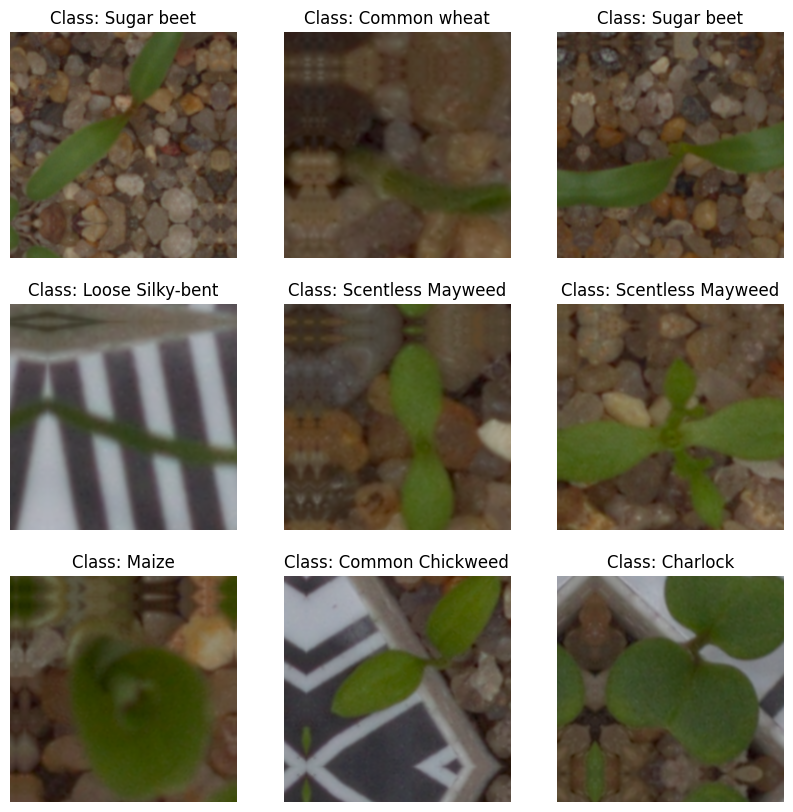

In [6]:
import matplotlib.pyplot as plt
import numpy as np

class_names = train_generator.class_names

plt.figure(figsize=(10, 10))
for images, labels in combined_train_dataset.take(1):  # Pegar um lote de imagens
    for i in range(9):  # Mostrar 9 imagens
        augmented_image = images[i]
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy())
        plt.title(f"Class: {class_name}")
        plt.axis("off")
plt.show()

### Expandindo o Dataset com Data Augmentation

In [9]:
# Contar o número total de imagens no conjunto de treino
total_images = sum(1 for _ in combined_train_dataset.unbatch())
print(f"Total de imagens no conjunto de treino: {total_images}")

Total de imagens no conjunto de treino: 8872


# Construção e Treinamento da NN

Para um modelo do zero, construir as camadas:

- Conv2D: Para extrair características.
- Pooling (MaxPooling2D): Para reduzir dimensionalidade.
- Dropout: Para evitar overfitting.
- Dense: Para tomar decisões baseadas nas características extraídas.

# Avaliação e Teste

- Avaliação no set de Teste
- Matriz de Confusão
- Acurácia Geral

In [10]:
#normalizar imagens do conjunto de teste
def normalize_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

normalized_validation_dataset = validation_dataset.map(normalize_images)